In [1]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [2]:
from arch import arch_model

In [3]:
with open('config.json') as file:
    config = json.load(file)

In [4]:
files_folder = config['files_folders']['processed']
research_results_folder = config['files_folders']['research_results']
antecedent_params_folder = config['files_folders']['antecedent_params_sets']

# Main input data

In [5]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [6]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

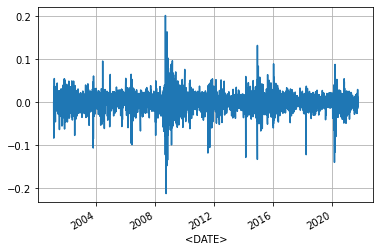

In [7]:
rtsi['log return'].plot()

plt.grid()
plt.show()

## Start date

In [8]:
rescale_factor = 100
start_date = '2014-01-01'

input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

In [9]:
n = input_data.shape[0]

In [10]:
n

1964

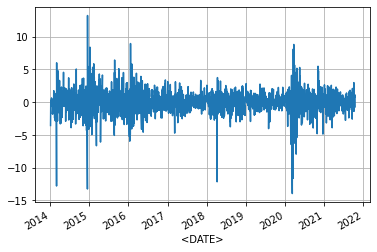

In [11]:
input_data.plot()

plt.grid()
plt.show()

In [12]:
input_data.describe()

count    1964.000000
mean        0.013812
std         1.826568
min       -13.948614
25%        -0.899103
50%         0.071543
75%         0.935148
max        13.246192
Name: log return, dtype: float64

In [13]:
days_of_week = pd.Series(input_data.index.dayofweek, index=input_data.index, name='day of week').copy()

## train & test split 

In [14]:
input_data.shape

(1964,)

In [15]:
n_train = 100  # 2000

n_test = 10
n_test = min(n - n_train, n_test)

In [16]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:(n_train + n_test)].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

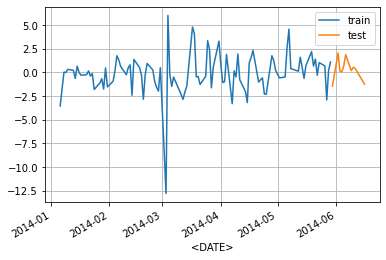

In [17]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [18]:
train.describe()

count    100.000000
mean      -0.092526
std        2.163714
min      -12.795677
25%       -0.982087
50%       -0.067699
75%        0.787302
max        6.017611
Name: log return, dtype: float64

# Consequent

In [19]:
# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
first_h = np.array(first_h)

In [20]:
train_sample_std

2.163714165933207

In [21]:
first_h

array([4.68165899])

## Using classic GARCH to get initial parameters values

In [22]:
garch_mean = 'Zero'
garch_dist = 'normal'

garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 224.92398317397047
Iteration:      2,   Func. Count:     13,   Neg. LLF: 219.79943267590863
Iteration:      3,   Func. Count:     18,   Neg. LLF: 217.77485889463415
Iteration:      4,   Func. Count:     23,   Neg. LLF: 217.26693911801357
Iteration:      5,   Func. Count:     27,   Neg. LLF: 217.43521932030816
Iteration:      6,   Func. Count:     32,   Neg. LLF: 217.2291730585139
Iteration:      7,   Func. Count:     36,   Neg. LLF: 217.22478250215488
Iteration:      8,   Func. Count:     40,   Neg. LLF: 217.22476113198286
Iteration:      9,   Func. Count:     43,   Neg. LLF: 217.22476113228768
Optimization terminated successfully    (Exit mode 0)
            Current function value: 217.22476113198286
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9


In [23]:
garch_fitted.params

omega       2.430453e-01
alpha[1]    1.627996e-11
beta[1]     9.533994e-01
Name: params, dtype: float64

In [24]:
alpha_0_ini_vanilla = garch_fitted.params.iloc[0]
alpha_ini_vanilla = garch_fitted.params.iloc[1:(q + 1)].values
beta_ini_vanilla = garch_fitted.params.iloc[(q + 1):].values

In [25]:
consequent_params_ini_vanilla = \
    {'alpha_0': alpha_0_ini_vanilla, 'alpha': alpha_ini_vanilla, 'beta': beta_ini_vanilla}

## Setting dict w/ all consequent meta parameters

In [26]:
consequent_metaparams = {'p': p, 'q': q, 'first_h': first_h}

##### `parameters_ini` and `bounds` not yet set!

## setting `parameters_ini` in consequent

In [27]:
# alpha_0_ini = np.array([alpha_0_ini_vanilla] * n_clusters)
# alpha_ini = np.array([alpha_ini_vanilla] * n_clusters).T
# beta_ini = np.array([beta_ini_vanilla] * n_clusters).T

consequent_params_ini = {'alpha_0': alpha_0_ini_vanilla,
                         'alpha': alpha_ini_vanilla,
                         'beta': beta_ini_vanilla}

consequent_metaparams['parameters_ini'] = consequent_params_ini

In [28]:
consequent_params_ini

{'alpha_0': 0.24304534026058858,
 'alpha': array([1.62799605e-11]),
 'beta': array([0.95339937])}

## Setting consequent parameters constraints (passed to LS)

In [29]:
# lower_bounds = [0] * ((1 + p + q) * n_clusters)
# upper_bounds = [+np.inf] * n_clusters + [1] * ((p + q) * n_clusters)
# bounds = (lower_bounds, upper_bounds)

lower_bounds = [0] * ((1 + p + q))
upper_bounds = [+np.inf] + [1] * ((p + q))
bounds = (lower_bounds, upper_bounds)

consequent_metaparams['bounds'] = bounds

# Antecedent params

In [36]:
# file_name = '2022-02-01_06-25.json'
# with open(f'{antecedent_params_folder}/{file_name}', 'r') as file:
#     antecedent_params_set = json.load(file)

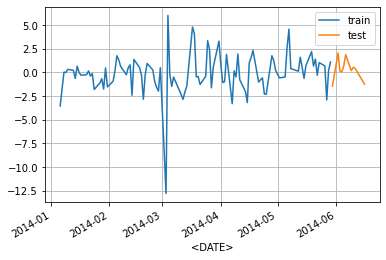

In [17]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [39]:
antecedent_params_set

[{'centers': [-10, -2, 2, 4], 'variances': [4, 4, 4, 4], 'n_clusters': 4},
 {'centers': [-10, -2, 2, 4], 'variances': [2, 4, 4, 2], 'n_clusters': 4},
 {'centers': [-10, -2, 2, 4], 'variances': [4, 2, 2, 4], 'n_clusters': 4}]

In [46]:
antecedent_params_set = [
    {
        'centers': [-7.5, -1.5, 1.5, 4],
        'variances': [6, 4, 4, 6],
        'n_clusters': 4
    },
    {
        'centers': [-7.5, -1.5, 1.5, 4],
        'variances': [6, 2, 2, 6],
        'n_clusters': 4
    },
    {
        'centers': [-7.5, -1.5, 1.5, 4],
        'variances': [8, 2, 2, 6],
        'n_clusters': 4
    }
]

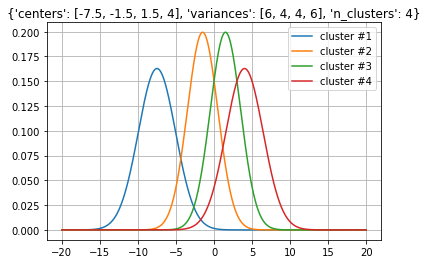

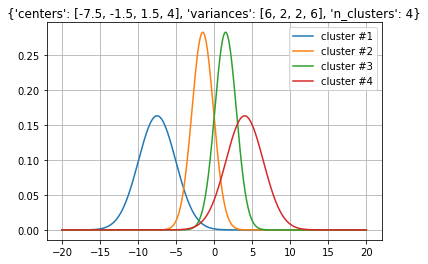

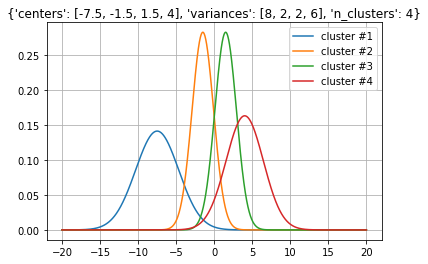

In [48]:
# plt.figure(figsize=(13, 7))

for _antecedent_params in antecedent_params_set:
    _centers = _antecedent_params['centers']
    _variances = _antecedent_params['variances']
    _n_clusters = _antecedent_params['n_clusters']
    
    for i in range(_n_clusters):
        _range = np.arange(-20, 20, .01)
        _data = sts.norm(_centers[i], _variances[i] ** .5).pdf(_range)

        plt.plot(_range, _data, label=f'cluster #{i + 1}')
    
    plt.title(_antecedent_params)
    plt.legend()
    plt.grid()
    plt.show()

# Data to cluster

In [49]:
data_to_cluster_train = 'train'
data_to_cluster_test = None

# Clusterization method

In [50]:
clusterization_method = 'gaussian'

# Aggregating all data to one dict

In [51]:
data = {
    'train': train,
    'test': test,
    'consequent_metaparams': consequent_metaparams,
    'consequent_params_ini': consequent_params_ini,
    'antecedent_params_set': antecedent_params_set,
    'clusterization_method': clusterization_method,
    'local_method': local_method,
    'data_to_cluster_train': data_to_cluster_train,
    'data_to_cluster_test': data_to_cluster_test
}

# Dumping

In [52]:
_file_name = 'current_antecedent_fitting_metadata.pkl'
with open(f'{antecedent_params_folder}/{_file_name}', 'wb') as file:
    pickle.dump(data, file)